In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lst_years = []
for i in range(24):
    year = 2000 + i
    year = str(year)
    lst_years.append(year)

# Economic Conditions

In [3]:
excel_file = pd.ExcelFile('S&P_US.xlsx')

dfa = {}
for sheet_name in excel_file.sheet_names:
    dfa[sheet_name] = excel_file.parse(sheet_name)

df_sp_500 = dfa['S&P_500']
df_treasuries = dfa['US_Treasuries'][['year', 'average_yield']]
df_treasuries = df_treasuries.rename(columns={'average_yield':'US Treasuries'}) 
df_treasuries = df_treasuries.drop(df_treasuries.index[-1])

# S&P 500 Composite
df_sp_500['Next S&P 500'] = df_sp_500['S&P 500'].shift(1)
df_sp_500['year'] = df_sp_500['year'].shift(1)
df_sp_500['SP_500_return'] = (df_sp_500['Next S&P 500'] - df_sp_500['S&P 500']) / df_sp_500['S&P 500']
df_sp_500 = df_sp_500[['year', 'SP_500_return']].drop(0)
df_sp_500['year'] = df_sp_500['year'].astype(int)

In [4]:
lst_sp_500 = df_sp_500['SP_500_return'].to_list()
lst_treasuries = df_treasuries['US Treasuries'].to_list()

# Traditional Factor-Based Portfolios

In [5]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)


for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company", "Sector"], axis=1).median()
    for column in df_reset.index:
        dfs[lst_years[i]][column].fillna(value=df_reset[column], inplace=True)
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]

## 1. Construction

In [6]:
df_basic_portfolio = pd.DataFrame()
df_basic_portfolio['year'] = lst_years[1:]

### 1.1. Momentum

In [7]:
dict_momentum = {}
momentum_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Return'] > 0]['Company'].to_list()
    dict_momentum[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    momentum_return.append(ret)
    
df_basic_portfolio['momentum'] = momentum_return

### 1.2. Size

In [8]:
dict_size = {}
size_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Market Value'] < df_first['Market Value'].mean()]['Company'].to_list()
    dict_size[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    size_return.append(ret)
    
df_basic_portfolio['size'] = size_return

### 1.3. Value

In [9]:
dict_value = {}
value_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['P/E'] < df_first['P/E'].mean()]['Company'].to_list()
    dict_value[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    value_return.append(ret)
    
df_basic_portfolio['value'] = value_return

### 1.4. Quality

In [10]:
dict_quality = {}
quality_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['EPS'] > df_first['EPS'].mean()]['Company'].to_list()
    dict_quality[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    quality_return.append(ret)
    
df_basic_portfolio['quality'] = quality_return

### 1.5. Yield

In [11]:
dict_yield = {}
yield_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Dividend Yield'] > df_first['Dividend Yield'].mean()]['Company'].to_list()
    dict_yield[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    yield_return.append(ret)
    
df_basic_portfolio['yield'] = yield_return

### 1.6. Volatility

In [12]:
dict_volatility = {}
volatility_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Beta'] < df_first['Beta'].mean()]['Company'].to_list()
    dict_volatility[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    volatility_return.append(ret)
    
df_basic_portfolio['volatility'] = volatility_return

## 2. Portfolios Analysis

In [13]:
df_basic_portfolio['S&P Return'] = lst_sp_500
df_basic_portfolio['US Treasuries'] = lst_treasuries

df_basic_portfolio.set_index('year', inplace=True)
df_basic_portfolio_cum = df_basic_portfolio.cumsum(axis=0).reset_index()

# Сохранение DataFrame в Excel на разные листы
with pd.ExcelWriter('results.xlsx') as writer:
    df_basic_portfolio.to_excel(writer, sheet_name='basic_portfolio')
    df_basic_portfolio_cum.to_excel(writer, sheet_name='basic_portfolio_cum')

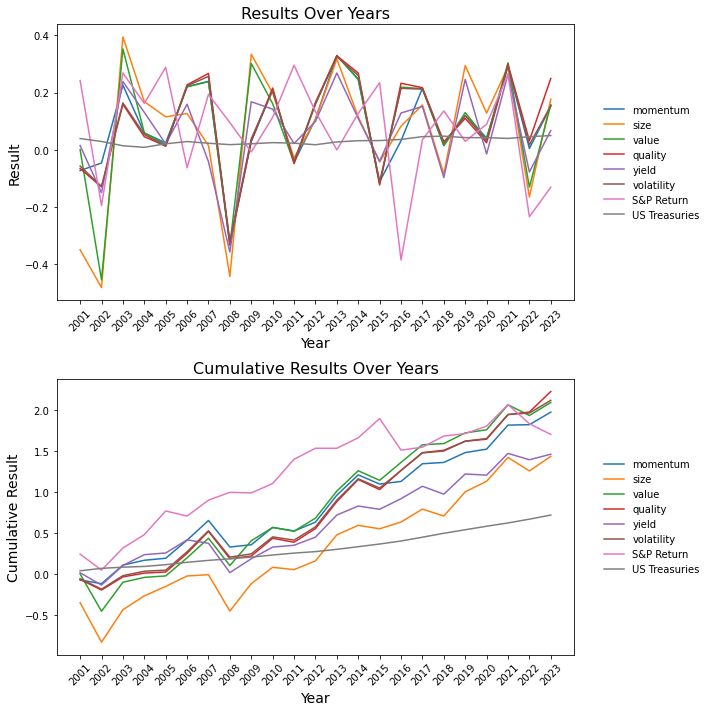

In [14]:
#df_basic_portfolio.set_index('year', inplace=True)
df_basic_portfolio_cum.set_index('year', inplace=True)

df_basic_portfolio.index = df_basic_portfolio.index.astype(int)
df_basic_portfolio_cum.index = df_basic_portfolio_cum.index.astype(int)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_basic_portfolio.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_basic_portfolio.index)
axs[0].set_xticklabels(df_basic_portfolio.index, rotation=45)

# Построим график для кумулятивных результатов
df_basic_portfolio_cum.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_basic_portfolio_cum.index)
axs[1].set_xticklabels(df_basic_portfolio_cum.index, rotation=45)

plt.tight_layout()
plt.show()

In [15]:
df_basic_portfolio.reset_index(inplace=True)
df_basic_portfolio = df_basic_portfolio.drop(['year'], axis=1).mean()

df_basic_portfolio_cum.reset_index(inplace=True)
df_basic_portfolio_cum = df_basic_portfolio_cum.tail(1).drop('year', axis=1)

factors = list(df_basic_portfolio_cum.index)
mean_basic_portfolio = list(df_basic_portfolio.values)
mean_cum_basic_portfolio = np.array(list(df_basic_portfolio_cum.values)).flatten().tolist()

#df = pd.DataFrame(list(zip(factors, mean_basic_portfolio, mean_cum_basic_portfolio)), 
#                  columns=['Factors', 'Mean_Basic', 'Cum_Mean_Basic'])

__Данные:__
* `df_basic_portfolio` - датафрейм результатов традиционных факторных портфелей
* `df_basic_portfolio_cum` - датафрейм кумулятивных результатов традиционных факторных портфелей

In [16]:
grouped_lists = np.array_split(list(zip(mean_basic_portfolio, mean_cum_basic_portfolio)), 1)

df = pd.DataFrame({
    'results': ['Mean_Basic', 'Cum_Mean_Basic'],
    'momentum': list(grouped_lists[0][0]), 
    'size' : list(grouped_lists[0][1]), 
    'value': list(grouped_lists[0][2]), 
    'quality': list(grouped_lists[0][3]), 
    'yield': list(grouped_lists[0][4]), 
    'volatility': list(grouped_lists[0][5])})

df

,results,momentum,size,value,quality,yield,volatility
0,Mean_Basic,0.085745,0.062319,0.090848,0.096665,0.063469,0.091995
1,Cum_Mean_Basic,1.972130,1.433337,2.089505,2.223287,1.459786,2.115874


<div style="border-bottom: 5px solid black;"></div>

# Traditional Factor-Based Portfolios with Industry Adjustments

In [17]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)
    

for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company"], axis=1).groupby(by="Sector").median()
    dfs[lst_years[i]] = dfs[lst_years[i]].set_index('Sector').combine_first(df_reset).reset_index()
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]
    #dfs[lst_years[i]].isnull().sum()

## 1. Construction

In [18]:
df_basic_portfolio_w_adj = pd.DataFrame()
df_basic_portfolio_w_adj['year'] = lst_years[1:]

### 1.1. Momentum

In [19]:
dict_momentum_adj = {}
momentum_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Return'] > 0]['Company'].to_list()
    dict_momentum_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    momentum_return.append(ret)
    
df_basic_portfolio_w_adj['momentum'] = momentum_return

### 1.2. Size

In [20]:
dict_size_adj = {}
size_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Market Value'] < df_first['Market Value'].mean()]['Company'].to_list()
    dict_size_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    size_return.append(ret)
    
df_basic_portfolio_w_adj['size'] = size_return

### 1.3. Value

In [21]:
dict_value_adj = {}
value_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['P/E'] < df_first['P/E'].mean()]['Company'].to_list()
    dict_value_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    value_return.append(ret)
    
df_basic_portfolio_w_adj['value'] = value_return

### 1.4. Quality

In [22]:
dict_quality_adj = {}
quality_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['EPS'] > df_first['EPS'].mean()]['Company'].to_list()
    dict_quality_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    quality_return.append(ret)
    
df_basic_portfolio_w_adj['quality'] = quality_return

### 1.5. Yield

In [23]:
dict_yield_adj = {}
yield_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Dividend Yield'] > df_first['Dividend Yield'].mean()]['Company'].to_list()
    dict_yield_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    yield_return.append(ret)
    
df_basic_portfolio_w_adj['yield'] = yield_return

### 1.6. Volatility

In [24]:
dict_volatility_adj = {}
volatility_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.loc[df_first['Beta'] < df_first['Beta'].mean()]['Company'].to_list()
    dict_volatility_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    volatility_return.append(ret)
    
df_basic_portfolio_w_adj['volatility'] = volatility_return

## 2. Portfolios Analysis

In [25]:
df_basic_portfolio_w_adj['S&P Return'] = lst_sp_500
df_basic_portfolio_w_adj['US Treasuries'] = lst_treasuries

df_basic_portfolio_w_adj.set_index('year', inplace=True)
df_basic_portfolio_w_adj_cum = df_basic_portfolio_w_adj.cumsum(axis=0).reset_index()

# Сохранение DataFrame в Excel на разные листы
#with pd.ExcelWriter('results.xlsx', mode='a') as writer:
#    df_basic_portfolio_w_adj.to_excel(writer, sheet_name='basic_portfolio_adj')
#    df_basic_portfolio_w_adj_cum.to_excel(writer, sheet_name='basic_portfolio_adj_cum')

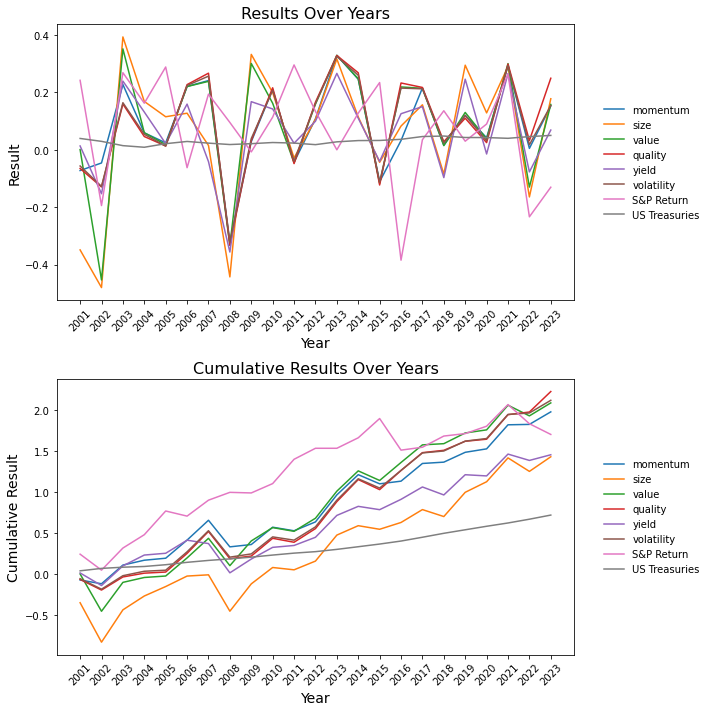

In [26]:
#df_basic_portfolio_w_adj.set_index('year', inplace=True)
df_basic_portfolio_w_adj_cum.set_index('year', inplace=True)

df_basic_portfolio_w_adj.index = df_basic_portfolio_w_adj.index.astype(int)
df_basic_portfolio_w_adj_cum.index = df_basic_portfolio_w_adj_cum.index.astype(int)

# Сглаживание данных с помощью интерполяции
df_basic_portfolio_w_adj = df_basic_portfolio_w_adj.interpolate(method='spline', order=5)
df_basic_portfolio_w_adj_cum = df_basic_portfolio_w_adj_cum.interpolate(method='spline', order=5)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_basic_portfolio_w_adj.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_basic_portfolio_w_adj.index)
axs[0].set_xticklabels(df_basic_portfolio_w_adj.index, rotation=45)

# Построим график для кумулятивных результатов
df_basic_portfolio_w_adj_cum.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_basic_portfolio_w_adj_cum.index)
axs[1].set_xticklabels(df_basic_portfolio_w_adj_cum.index, rotation=45)

plt.tight_layout()
plt.show()

In [27]:
df_basic_portfolio_w_adj.reset_index(inplace=True)
df_basic_portfolio_w_adj = df_basic_portfolio_w_adj.drop(['year'], axis=1).mean()

df_basic_portfolio_w_adj_cum.reset_index(inplace=True)
df_basic_portfolio_w_adj_cum = df_basic_portfolio_w_adj_cum.tail(1).drop('year', axis=1)

#factors = list(df_basic_portfolio_w_adj.index)
mean_basic_portfolio_w_adj = list(df_basic_portfolio_w_adj.values)
mean_cum_basic_portfolio_w_adj = np.array(list(df_basic_portfolio_w_adj_cum.values)).flatten().tolist()

#df = pd.DataFrame(list(zip(factors, mean_basic_portfolio, mean_cum_basic_portfolio)), 
#                  columns=['Factors', 'Mean_Basic', 'Cum_Mean_Basic'])

__Данные:__
* `df_basic_portfolio` - датафрейм результатов традиционных факторных портфелей
* `df_basic_portfolio_cum` - датафрейм кумулятивных результатов традиционных факторных портфелей
* `df_basic_portfolio_w_adj` - датафрейм результатов традиционных факторных портфелей с корректировкой на сектор
* `df_basic_portfolio_w_adj_cum` - датафрейм кумулятивных результатов традиционных факторных портфелей с корректировкой на сектор

In [28]:
grouped_lists = np.array_split(list(zip(mean_basic_portfolio_w_adj, mean_cum_basic_portfolio_w_adj)), 1)

df_1 = pd.DataFrame({
    'results': ['Mean_Basic', 'Cum_Mean_Basic', 'Mean_Basic_Adj', 'Cum_Mean_Basic_Adj'],
    'momentum': list(df.momentum) + list(grouped_lists[0][0]), 
    'size' : list(df['size']) + list(grouped_lists[0][1]), 
    'value': list(df.value) + list(grouped_lists[0][2]), 
    'quality': list(df.quality) + list(grouped_lists[0][3]), 
    'yield': list(df['yield']) + list(grouped_lists[0][4]), 
    'volatility': list(df.volatility) + list(grouped_lists[0][5])})

df_1

,results,momentum,size,value,quality,yield,volatility
0,Mean_Basic,0.085745,0.062319,0.090848,0.096665,0.063469,0.091995
1,Cum_Mean_Basic,1.972130,1.433337,2.089505,2.223287,1.459786,2.115874
2,Mean_Basic_Adj,0.085905,0.062115,0.090647,0.096665,0.063177,0.092017
3,Cum_Mean_Basic_Adj,1.975815,1.428637,2.084877,2.223287,1.453073,2.116399


In [29]:
series = pd.Series(lst_sp_500)
series.mean()

0.0739430310606663

 - dict_momentum
 - dict_size
 - dict_value
 - dict_quality
 - dict_volatility
 ---
 - dict_momentum_adj
 - dict_size_adj
 - dict_value_adj
 - dict_quality_adj
 - dict_volatility_adj

<div style="border-bottom: 5px solid black;"></div>

# Traditional Factor-Based Portfolios - 10

In [30]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)


for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company", "Sector"], axis=1).median()
    for column in df_reset.index:
        dfs[lst_years[i]][column].fillna(value=df_reset[column], inplace=True)
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]

## 1. Construction

In [31]:
df_basic_portfolio_10 = pd.DataFrame()
df_basic_portfolio_10['year'] = lst_years[1:]

### 1.1. Momentum

In [32]:
dict_momentum_10 = {}
momentum_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'Return')['Company'].to_list()
    dict_momentum_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    momentum_return.append(ret)
    
df_basic_portfolio_10['momentum'] = momentum_return

### 1.2. Size

In [33]:
dict_size_10 = {}
size_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'Market Value')['Company'].to_list()
    dict_size_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    size_return.append(ret)
    
df_basic_portfolio_10['size'] = size_return

### 1.3. Value

In [34]:
dict_value_10 = {}
value_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'P/E')['Company'].to_list()
    dict_value_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    value_return.append(ret)
    
df_basic_portfolio_10['value'] = value_return

### 1.4. Quality

In [35]:
dict_quality_10 = {}
quality_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'EPS')['Company'].to_list() 
    dict_quality_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    quality_return.append(ret)
    
df_basic_portfolio_10['quality'] = quality_return

### 1.5. Yield

In [36]:
dict_yield_10 = {}
yield_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'Dividend Yield')['Company'].to_list()
    dict_yield_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    yield_return.append(ret)
    
df_basic_portfolio_10['yield'] = yield_return

### 1.6. Volatility

In [37]:
dict_volatility_10 = {}
volatility_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'Beta')['Company'].to_list()
    dict_volatility_10[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    volatility_return.append(ret)
    
df_basic_portfolio_10['volatility'] = volatility_return

## 2. Portfolios Analysis

In [38]:
df_basic_portfolio_10['S&P Return'] = lst_sp_500
df_basic_portfolio_10['US Treasuries'] = lst_treasuries

df_basic_portfolio_10.set_index('year', inplace=True)
df_basic_portfolio_10_cum = df_basic_portfolio_10.cumsum(axis=0)

# Сохранение DataFrame в Excel на разные листы
with pd.ExcelWriter('results_10.xlsx', mode='a', engine='openpyxl') as writer:
    df_basic_portfolio_10.to_excel(writer, sheet_name='basic_portfolio_10')
    df_basic_portfolio_10_cum.to_excel(writer, sheet_name='basic_portfolio_10_cum')

In [39]:
df_basic_portfolio_10 = df_basic_portfolio_10.reset_index()
df_basic_portfolio_10_cum = df_basic_portfolio_10_cum.reset_index()

df_basic_portfolio_10.set_index('year', inplace=True)
df_basic_portfolio_10_cum.set_index('year', inplace=True)

df_basic_portfolio_10.index = df_basic_portfolio_10.index.astype(int)
df_basic_portfolio_10_cum.index = df_basic_portfolio_10_cum.index.astype(int)

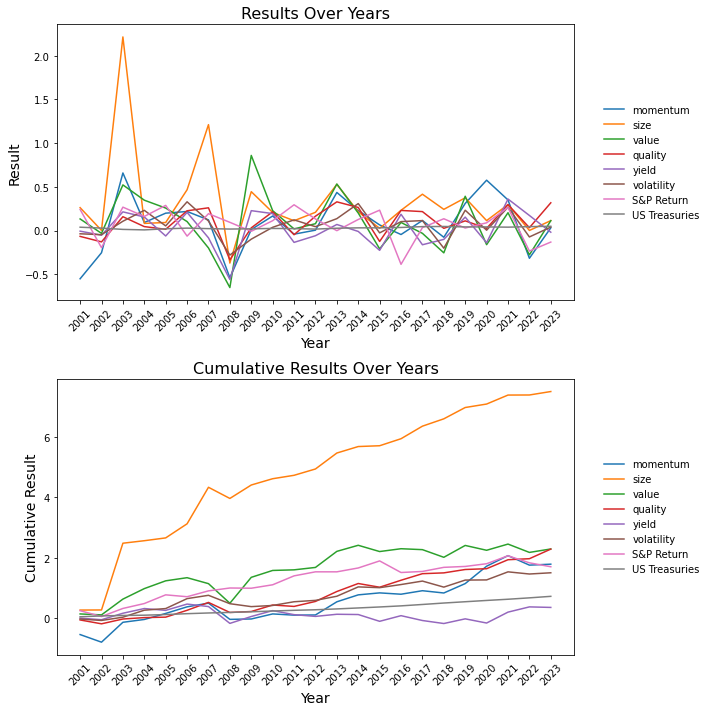

In [40]:
# Сглаживание данных с помощью интерполяции
df_basic_portfolio_10 = df_basic_portfolio_10.interpolate(method='spline', order=5)
df_basic_portfolio_10_cum = df_basic_portfolio_10_cum.interpolate(method='spline', order=5)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_basic_portfolio_10.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_basic_portfolio_10.index)
axs[0].set_xticklabels(df_basic_portfolio_10.index, rotation=45)

# Построим график для кумулятивных результатов
df_basic_portfolio_10_cum.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_basic_portfolio_10_cum.index)
axs[1].set_xticklabels(df_basic_portfolio_10_cum.index, rotation=45)

plt.tight_layout()
plt.show()

In [41]:
df_basic_portfolio_10.reset_index(inplace=True)
df_basic_portfolio_10 = df_basic_portfolio_10.drop(['year'], axis=1).mean()

df_basic_portfolio_10_cum.reset_index(inplace=True)
df_basic_portfolio_10_cum = df_basic_portfolio_10_cum.tail(1).drop('year', axis=1)

#factors = list(df_basic_portfolio_w_adj.index)
mean_basic_portfolio_10 = list(df_basic_portfolio_10.values)
mean_cum_basic_portfolio_10 = np.array(list(df_basic_portfolio_10_cum.values)).flatten().tolist()

#df = pd.DataFrame(list(zip(factors, mean_basic_portfolio, mean_cum_basic_portfolio)), 
#                  columns=['Factors', 'Mean_Basic', 'Cum_Mean_Basic'])

In [42]:
grouped_lists = np.array_split(list(zip(mean_basic_portfolio_10, mean_cum_basic_portfolio_10)), 1)

df_2 = pd.DataFrame({
    'results': ['Mean_Basic', 'Cum_Basic', 'Mean_Basic_Adj', 'Cum_Basic_Adj', 'Mean_Basic_10', 'Çum_Basic_10'],
    'momentum': list(df_1.momentum) + list(grouped_lists[0][0]), 
    'size' : list(df_1['size']) + list(grouped_lists[0][1]), 
    'value': list(df_1.value) + list(grouped_lists[0][2]), 
    'quality': list(df_1.quality) + list(grouped_lists[0][3]), 
    'yield': list(df_1['yield']) + list(grouped_lists[0][4]), 
    'volatility': list(df_1.volatility) + list(grouped_lists[0][5])})

df_2

,results,momentum,size,value,quality,yield,volatility
0,Mean_Basic,0.085745,0.062319,0.090848,0.096665,0.063469,0.091995
1,Cum_Basic,1.972130,1.433337,2.089505,2.223287,1.459786,2.115874
2,Mean_Basic_Adj,0.085905,0.062115,0.090647,0.096665,0.063177,0.092017
3,Cum_Basic_Adj,1.975815,1.428637,2.084877,2.223287,1.453073,2.116399
4,Mean_Basic_10,0.077660,0.326815,0.099596,0.099418,0.015247,0.065242
5,Çum_Basic_10,1.786171,7.516742,2.290699,2.286616,0.350687,1.500557


<div style="border-bottom: 5px solid black;"></div>

# Traditional Factor-Based Portfolios - 10 - with Industry Adjustments

In [43]:
excel_file = pd.ExcelFile('Data_Python.xlsx')

dfs = {}
for sheet_name in excel_file.sheet_names:
    dfs[sheet_name] = excel_file.parse(sheet_name)
    

for i in range(24):
    # Для замены пропущенных символов была взята медиана, а не среднее в целях сокращения влияния выбросов 
    df_reset = dfs[lst_years[i]].drop(["Symbol", "Company"], axis=1).groupby(by="Sector").median()
    dfs[lst_years[i]] = dfs[lst_years[i]].set_index('Sector').combine_first(df_reset).reset_index()
    dfs[lst_years[i]]['EV/EBITDA'] = dfs[lst_years[i]]['EV'] / dfs[lst_years[i]]['EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]].drop('Symbol', axis=1)
    column_order = ['Company', 'Sector', 'Share price_cur', 'Share price_Y-1', 'Beta', 'Market Value',
                    'Revenue', 'EBITDA', 'EV', 'Book Value', 'EPS', 'DPS', 'Dividend Yield', 'D/E', 'D/total Cap', 
                    'EV/EBITDA', 'Current Ratio', 'Quick Ratio', 'P/BV', 'P/E', 'ROA', 'ROE', 'ROIC', 
                    'Gross Profit margin', 'Operating profit margin', 'Net profit margin',
                    'EPS 1Y growth', 'EPS 3Y growth', 'EPS 5Y growth', 
                    '12M forward EPS', '12M forward Earn. Yield', 'fwd 12M EV/EBITDA']
    dfs[lst_years[i]] = dfs[lst_years[i]][column_order]
    #dfs[lst_years[i]].isnull().sum()

## 1. Construction

In [44]:
df_basic_portfolio_10_adj = pd.DataFrame()
df_basic_portfolio_10_adj['year'] = lst_years[1:]

### 1.1. Momentum

In [45]:
dict_momentum_10_adj = {}
momentum_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'Return')['Company'].to_list()
    dict_momentum_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    momentum_return.append(ret)
    
df_basic_portfolio_10_adj['momentum'] = momentum_return

### 1.2. Size

In [46]:
dict_size_10_adj = {}
size_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'Market Value')['Company'].to_list()
    dict_size_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Market Value']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    size_return.append(ret)
    
df_basic_portfolio_10_adj['size'] = size_return

### 1.3. Value

In [47]:
dict_value_10_adj = {}
value_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'P/E')['Company'].to_list()
    dict_value_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'P/E']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    value_return.append(ret)
    
df_basic_portfolio_10_adj['value'] = value_return

### 1.4. Quality

In [48]:
dict_quality_10_adj = {}
quality_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'EPS')['Company'].to_list() 
    dict_quality_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'EPS']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    quality_return.append(ret)
    
df_basic_portfolio_10_adj['quality'] = quality_return

### 1.5. Yield

In [49]:
dict_yield_10_adj = {}
yield_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nlargest(10, 'Dividend Yield')['Company'].to_list()
    dict_yield_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Dividend Yield']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    yield_return.append(ret)
    
df_basic_portfolio_10_adj['yield'] = yield_return

### 1.6. Volatility

In [50]:
dict_volatility_10_adj = {}
volatility_return = []

for i in range(23):
    df_first = dfs[lst_years[i]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_first['Return'] = (df_first['Share price_cur'] - df_first['Share price_Y-1']) / df_first['Share price_Y-1']
    
    lst_positive = df_first.nsmallest(10, 'Beta')['Company'].to_list()
    dict_volatility_10_adj[str(lst_years[i])] = lst_positive
    
    df_second = dfs[lst_years[i + 1]][['Company', 'Share price_cur', 'Share price_Y-1', 'Beta']].copy()
    df_second = df_second[df_second['Company'].isin(lst_positive)]
    df_second['Return'] = (df_second['Share price_cur'] - df_second['Share price_Y-1']) / df_second['Share price_Y-1']
    
    ret = (df_second['Share price_cur'].sum() - df_second['Share price_Y-1'].sum()) / df_second['Share price_Y-1'].sum()
    volatility_return.append(ret)
    
df_basic_portfolio_10_adj['volatility'] = volatility_return

## 2. Portfolios Analysis

In [51]:
df_basic_portfolio_10_adj['S&P Return'] = lst_sp_500
df_basic_portfolio_10_adj['US Treasuries'] = lst_treasuries

df_basic_portfolio_10_adj.set_index('year', inplace=True)
df_basic_portfolio_10_adj_cum = df_basic_portfolio_10_adj.cumsum(axis=0).reset_index()

# Сохранение DataFrame в Excel на разные листы
with pd.ExcelWriter('results_10.xlsx', mode='a', engine='openpyxl') as writer:
    df_basic_portfolio_10_adj.to_excel(writer, sheet_name='basic_portfolio_adj')
    df_basic_portfolio_10_adj_cum.to_excel(writer, sheet_name='basic_portfolio_adj_cum')

In [52]:
df_basic_portfolio_10_adj = df_basic_portfolio_10_adj.reset_index()
#df_basic_portfolio_10_adj_cum = df_basic_portfolio_10_adj_cum.reset_index()

df_basic_portfolio_10_adj.set_index('year', inplace=True)
df_basic_portfolio_10_adj_cum.set_index('year', inplace=True)

df_basic_portfolio_10_adj.index = df_basic_portfolio_10_adj.index.astype(int)
df_basic_portfolio_10_adj_cum.index = df_basic_portfolio_10_adj_cum.index.astype(int)

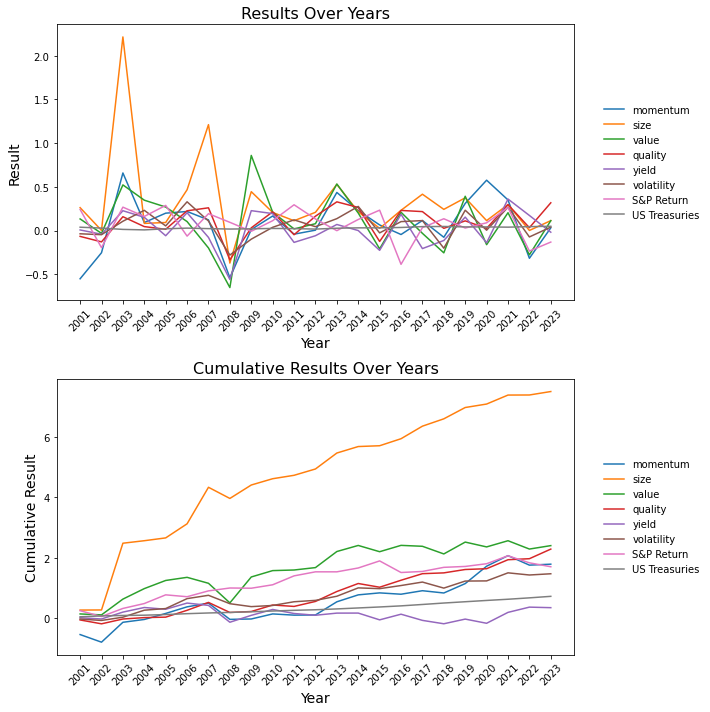

In [53]:
# Сглаживание данных с помощью интерполяции
df_basic_portfolio_10_adj = df_basic_portfolio_10_adj.interpolate(method='spline', order=5)
df_basic_portfolio_10_adj_cum = df_basic_portfolio_10_adj_cum.interpolate(method='spline', order=5)

# горизонтальное расположение
#fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# вертикальное расположение
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Построим график для обычных результатов
df_basic_portfolio_10_adj.plot(ax=axs[0], kind='line')
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Result', fontsize=14)
axs[0].set_title('Results Over Years', fontsize=16)
axs[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[0].set_xticks(df_basic_portfolio_10_adj.index)
axs[0].set_xticklabels(df_basic_portfolio_10_adj.index, rotation=45)

# Построим график для кумулятивных результатов
df_basic_portfolio_10_adj_cum.plot(ax=axs[1], kind='line')
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Cumulative Result', fontsize=14)
axs[1].set_title('Cumulative Results Over Years', fontsize=16)
axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0., frameon=False)

axs[1].set_xticks(df_basic_portfolio_10_adj_cum.index)
axs[1].set_xticklabels(df_basic_portfolio_10_adj_cum.index, rotation=45)

plt.tight_layout()
plt.show()

In [54]:
df_basic_portfolio_10_adj.reset_index(inplace=True)
df_basic_portfolio_10_adj = df_basic_portfolio_10_adj.drop(['year'], axis=1).mean()

df_basic_portfolio_10_adj_cum.reset_index(inplace=True)
df_basic_portfolio_10_adj_cum = df_basic_portfolio_10_adj_cum.tail(1).drop('year', axis=1)

#factors = list(df_basic_portfolio_w_adj.index)
mean_basic_portfolio_10_adj = list(df_basic_portfolio_10_adj.values)
mean_cum_basic_portfolio_10_adj = np.array(list(df_basic_portfolio_10_adj_cum.values)).flatten().tolist()

#df = pd.DataFrame(list(zip(factors, mean_basic_portfolio, mean_cum_basic_portfolio)), 
#                  columns=['Factors', 'Mean_Basic', 'Cum_Mean_Basic'])

In [55]:
grouped_lists = np.array_split(list(zip(mean_basic_portfolio_10_adj, mean_cum_basic_portfolio_10_adj)), 1)

df_3 = pd.DataFrame({
    'results': ['Mean_Basic', 'Cum_Basic', 'Mean_Basic_Adj', 'Cum_Basic_Adj', 
                'Mean_Basic_10', 'Çum_Basic_10', 'Mean_Basic_10_Adj', 'Cum_Basic_10_Adj'],
    'momentum': list(df_2.momentum) + list(grouped_lists[0][0]), 
    'size' : list(df_2['size']) + list(grouped_lists[0][1]), 
    'value': list(df_2.value) + list(grouped_lists[0][2]), 
    'quality': list(df_2.quality) + list(grouped_lists[0][3]), 
    'yield': list(df_2['yield']) + list(grouped_lists[0][4]), 
    'volatility': list(df_2.volatility) + list(grouped_lists[0][5])})

df_3

,results,momentum,size,value,quality,yield,volatility
0,Mean_Basic,0.085745,0.062319,0.090848,0.096665,0.063469,0.091995
1,Cum_Basic,1.972130,1.433337,2.089505,2.223287,1.459786,2.115874
2,Mean_Basic_Adj,0.085905,0.062115,0.090647,0.096665,0.063177,0.092017
3,Cum_Basic_Adj,1.975815,1.428637,2.084877,2.223287,1.453073,2.116399
4,Mean_Basic_10,0.077660,0.326815,0.099596,0.099418,0.015247,0.065242
5,Çum_Basic_10,1.786171,7.516742,2.290699,2.286616,0.350687,1.500557
6,Mean_Basic_10_Adj,0.077660,0.326815,0.104441,0.099418,0.014891,0.063817
7,Cum_Basic_10_Adj,1.786171,7.516742,2.402148,2.286616,0.342491,1.467791
